In [1]:
from pathlib import Path
import nibabel as nib
import numpy as np

data_dir = Path("/mnt/c/Users/sohel/Downloads/Ai_health/LITS17")

vols, segs = [], []
for case_id in range(0, 130):   # adjust number to how many you have
    vol_path = data_dir / f"volume-{case_id}.nii"
    seg_path = data_dir / f"segmentation-{case_id}.nii"
    if vol_path.exists() and seg_path.exists():
        vol = nib.load(str(vol_path)).get_fdata().astype(np.float32)
        seg = (nib.load(str(seg_path)).get_fdata() > 0).astype(np.uint8)
        vols.append(vol)
        segs.append(seg)
    else:
        print(f"⚠️ Missing case {case_id}")

print(f"Loaded {len(vols)} volumes")


⚠️ Missing case 0
⚠️ Missing case 1
⚠️ Missing case 2
⚠️ Missing case 3
⚠️ Missing case 4
⚠️ Missing case 5
⚠️ Missing case 6
⚠️ Missing case 7
⚠️ Missing case 8
⚠️ Missing case 9
⚠️ Missing case 10
⚠️ Missing case 11
⚠️ Missing case 12
⚠️ Missing case 13
⚠️ Missing case 14
⚠️ Missing case 15
⚠️ Missing case 16
⚠️ Missing case 17
⚠️ Missing case 18
⚠️ Missing case 19
⚠️ Missing case 20
⚠️ Missing case 21
⚠️ Missing case 22
⚠️ Missing case 23
⚠️ Missing case 24
⚠️ Missing case 25
⚠️ Missing case 26
⚠️ Missing case 27
⚠️ Missing case 28
⚠️ Missing case 29
⚠️ Missing case 30
⚠️ Missing case 31
⚠️ Missing case 32
⚠️ Missing case 33
⚠️ Missing case 34
⚠️ Missing case 35
⚠️ Missing case 36
⚠️ Missing case 37
⚠️ Missing case 38
⚠️ Missing case 39
⚠️ Missing case 40
⚠️ Missing case 41
⚠️ Missing case 42
⚠️ Missing case 43
⚠️ Missing case 44
⚠️ Missing case 45
⚠️ Missing case 46
⚠️ Missing case 47
⚠️ Missing case 48
⚠️ Missing case 49
⚠️ Missing case 50
⚠️ Missing case 51
⚠️ Missing case 52
⚠️ 

In [2]:
X_all = np.concatenate([v.transpose(2,0,1)[..., None] for v in vols])
Y_all = np.concatenate([s.transpose(2,0,1)[..., None] for s in segs])

print("Full dataset:", X_all.shape, Y_all.shape)


Full dataset: (733, 512, 512, 1) (733, 512, 512, 1)


In [3]:
subset_idx = np.random.choice(len(X_all), size=200, replace=False)
X_all = X_all[subset_idx]
Y_all = Y_all[subset_idx]


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(
    X_all, Y_all, test_size=0.1, random_state=42
)
print("Train:", X_train.shape, "Val:", X_val.shape)


Train: (180, 512, 512, 1) Val: (20, 512, 512, 1)


In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models

# --- Define U-Net ---
def build_unet(input_shape=(512, 512, 1)):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D(2)(c1)

    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D(2)(c2)

    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(c3)

    # Decoder
    u1 = layers.UpSampling2D(2)(c3)
    u1 = layers.Concatenate()([u1, c2])
    c4 = layers.Conv2D(32, 3, activation='relu', padding='same')(u1)
    c4 = layers.Conv2D(32, 3, activation='relu', padding='same')(c4)

    u2 = layers.UpSampling2D(2)(c4)
    u2 = layers.Concatenate()([u2, c1])
    c5 = layers.Conv2D(16, 3, activation='relu', padding='same')(u2)
    c5 = layers.Conv2D(16, 3, activation='relu', padding='same')(c5)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c5)
    return models.Model(inputs, outputs, name="U-Net-2D")


In [7]:
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth=1.0):
    y_true_f = K.flatten(tf.cast(y_true, tf.float32))
    y_pred_f = K.flatten(tf.cast(y_pred, tf.float32))
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return bce + dice_loss(y_true, y_pred)


In [8]:
tf.keras.backend.clear_session()
model = build_unet(input_shape=(512, 512, 1))
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=['accuracy', dice_coef])
model.summary()


W0000 00:00:1762664766.325226  104267 cuda_executor.cc:1782] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W0000 00:00:1762664766.588631  104267 cuda_executor.cc:1782] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W0000 00:00:1762664766.588983  104267 cuda_executor.cc:1782] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W0000 00:00:1762664766.589014  104267 gpu_device.cc:2456] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0a. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
W0000 00:00:1762664766.592101  104267 cuda_executor.cc:1782] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not us

Model: "U-Net-2D"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 256, 256,  │          0 │ conv2d_5[0][0]    │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256, 256,  │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 96)               │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 256, 256,  │     27,680 │ concatenate[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 256, 256,  │      9,248 │ conv2d_6[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 512, 512,  │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 512, 512,  │          0 │ up_sampling2d_1[… │
│ (Concatenate)       │ 48)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 512, 512,  │      6,928 │ concatenate_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 512, 512,  │      2,320 │ conv2d_8[0][0]  

 Total params: 117,985 (460.88 KB)

 Trainable params: 117,985 (460.88 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_dice_coef', patience=5, mode='max', restore_best_weights=True),
    ModelCheckpoint("best_unet_lits17.keras", monitor='val_dice_coef', save_best_only=True, mode='max')
]

history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=30,
    batch_size=2,
    callbacks=callbacks
)


Epoch 1/30


I0000 00:00:1762664781.541523  106581 service.cc:158] XLA service 0x7dbc34007020 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762664781.541596  106581 service.cc:166]   StreamExecutor device (0): NVIDIA GeForce RTX 5060 Ti, Compute Capability 12.0a
I0000 00:00:1762664781.635597  106581 dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1762664781.965228  106581 cuda_dnn.cc:463] Loaded cuDNN version 91500


 7/90 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6632 - dice_coef: 0.0527 - loss: 3.7064

I0000 00:00:1762664787.405247  106581 device_compiler.h:208] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.9511 - dice_coef: 0.1412 - loss: 1.0489 - val_accuracy: 0.9574 - val_dice_coef: 0.3291 - val_loss: 0.7662
Epoch 2/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9680 - dice_coef: 0.2377 - loss: 0.8484 - val_accuracy: 0.9545 - val_dice_coef: 0.3004 - val_loss: 0.7870
Epoch 3/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9584 - dice_coef: 0.1946 - loss: 0.9164 - val_accuracy: 0.9621 - val_dice_coef: 0.2439 - val_loss: 0.8458
Epoch 4/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9726 - dice_coef: 0.2796 - loss: 0.7963 - val_accuracy: 0.9732 - val_dice_coef: 0.4927 - val_loss: 0.5734
Epoch 5/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9750 - dice_coef: 0.2903 - loss: 0.7789 - val_accuracy: 0.9740 - val_dice_coef: 0.5165 - val_loss: 0.5458
Epoch 6/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9754 - dice_coef: 0.2977 - loss: 0.7708 - val_accuracy: 0.9760 - val_dice_coef: 0.5050 - v

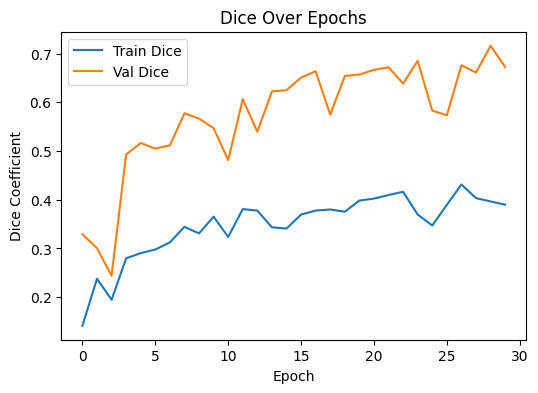

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(history.history['dice_coef'], label='Train Dice')
plt.plot(history.history['val_dice_coef'], label='Val Dice')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.title('Dice Over Epochs')
plt.legend()
plt.show()


In [11]:
val_loss, val_acc, val_dice = model.evaluate(X_val, Y_val, verbose=1)
print(f"Validation Dice: {val_dice:.4f}, Accuracy: {val_acc:.4f}, Loss: {val_loss:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.9861 - dice_coef: 0.8072 - loss: 0.2407
Validation Dice: 0.8072, Accuracy: 0.9861, Loss: 0.2407


In [12]:
from tensorflow import keras
model = keras.models.load_model("best_unet_lits17.keras", custom_objects={'bce_dice_loss': bce_dice_loss, 'dice_coef': dice_coef})


In [16]:
import nibabel as nib
import numpy as np
from pathlib import Path
import os

pred_dir = data_dir / "predictions"
os.makedirs(pred_dir, exist_ok=True)

for vol_path in sorted(data_dir.glob("volume-*.nii")):
    case_id = vol_path.stem.split("-")[1]
    seg_path = data_dir / f"segmentation-{case_id}.nii"
    if not seg_path.exists():
        print(f"Skipping {case_id}, missing segmentation.")
        continue

    vol = nib.load(str(vol_path)).get_fdata().astype(np.float32)
    preds = []
    for z in range(vol.shape[2]):
        sl = vol[:, :, z][None, :, :, None]
        pred = model.predict(sl, verbose=0)[0, :, :, 0]
        preds.append(pred)
    preds = np.stack(preds, axis=2)

    # save binary mask prediction
    pred_img = nib.Nifti1Image((preds > 0.5).astype(np.uint8), np.eye(4))
    nib.save(pred_img, pred_dir / f"segmentation_pred-{case_id}.nii.gz")
    print(f"✅ Saved prediction for case {case_id}")


Skipping 78, missing segmentation.
✅ Saved prediction for case 84


In [17]:
from pathlib import Path
data_dir = Path("/mnt/c/Users/sohel/Downloads/Ai_health/LITS17")

for f in sorted(data_dir.glob("*")):
    print(f.name)


LiTS17_UNet_portfolio.ipynb
analysis.ipynb
analysis1.ipynb
best_unet_lits17.h5
best_unet_lits17.keras
predictions
requirements.txt
segmentation-0.nii.zip
segmentation-1.nii.zip
segmentation-10.nii.zip
segmentation-100.nii.zip
segmentation-101.nii.zip
segmentation-102.nii.zip
segmentation-103.nii.zip
segmentation-104.nii.zip
segmentation-105.nii.zip
segmentation-106.nii.zip
segmentation-107.nii.zip
segmentation-108.nii.zip
segmentation-109.nii.zip
segmentation-11.nii.zip
segmentation-110.nii.zip
segmentation-111.nii.zip
segmentation-112.nii.zip
segmentation-113.nii.zip
segmentation-114.nii.zip
segmentation-115.nii.zip
segmentation-116.nii.zip
segmentation-117.nii.zip
segmentation-118.nii.zip
segmentation-119.nii.zip
segmentation-12.nii.zip
segmentation-120.nii.zip
segmentation-121.nii.zip
segmentation-122.nii.zip
segmentation-123.nii.zip
segmentation-124.nii.zip
segmentation-125.nii.zip
segmentation-126.nii.zip
segmentation-127.nii.zip
segmentation-128.nii.zip
segmentation-129.nii.zip
s

In [2]:
from pathlib import Path
import nibabel as nib
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models

# --------------------------------------------------------------------
# 1️⃣ Load just a few LiTS17 volumes and masks to avoid memory overflow
# --------------------------------------------------------------------
data_dir = Path("/mnt/c/Users/sohel/Downloads/Ai_health/LITS17")

# 👇 Pick 2–4 available case IDs that exist in your folder
selected_cases = [70, 72, 84, 87]

vols, segs = [], []
for case_id in selected_cases:
    vol_path = data_dir / f"volume-{case_id}.nii"
    seg_path = data_dir / f"segmentation-{case_id}.nii"
    if vol_path.exists() and seg_path.exists():
        vol = nib.load(str(vol_path)).get_fdata().astype(np.float32)
        seg = (nib.load(str(seg_path)).get_fdata() > 0).astype(np.uint8)
        vols.append(vol)
        segs.append(seg)
        print(f"✅ Loaded case {case_id}")
    else:
        print(f"⚠️ Missing case {case_id}")

print(f"✅ Total volumes loaded: {len(vols)}")

# --------------------------------------------------------------------
# 2️⃣ Convert 3D volumes to 2D slices (axial) and add channel dimension
# --------------------------------------------------------------------
X_all = np.concatenate([v.transpose(2,0,1)[..., None] for v in vols])
Y_all = np.concatenate([s.transpose(2,0,1)[..., None] for s in segs])

print("Full dataset:", X_all.shape, Y_all.shape)

# Randomly sample 150 slices for a small demo
subset_idx = np.random.choice(len(X_all), size=min(150, len(X_all)), replace=False)
X_all = X_all[subset_idx]
Y_all = Y_all[subset_idx]

# --------------------------------------------------------------------
# 3️⃣ Train / Validation split
# --------------------------------------------------------------------
X_train, X_val, Y_train, Y_val = train_test_split(
    X_all, Y_all, test_size=0.1, random_state=42
)
print("Train:", X_train.shape, "Val:", X_val.shape)

# --------------------------------------------------------------------
# 4️⃣ Define a compact 2D U-Net
# --------------------------------------------------------------------
def build_unet(input_shape=(512, 512, 1)):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D(2)(c1)

    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D(2)(c2)

    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(c3)

    # Decoder
    u1 = layers.UpSampling2D(2)(c3)
    u1 = layers.Concatenate()([u1, c2])
    c4 = layers.Conv2D(32, 3, activation='relu', padding='same')(u1)
    c4 = layers.Conv2D(32, 3, activation='relu', padding='same')(c4)

    u2 = layers.UpSampling2D(2)(c4)
    u2 = layers.Concatenate()([u2, c1])
    c5 = layers.Conv2D(16, 3, activation='relu', padding='same')(u2)
    c5 = layers.Conv2D(16, 3, activation='relu', padding='same')(c5)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c5)
    return models.Model(inputs, outputs, name="U-Net-2D")

# --------------------------------------------------------------------
# 5️⃣ Define loss & metrics (Dice + BCE)
# --------------------------------------------------------------------
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth=1.0):
    y_true_f = K.flatten(tf.cast(y_true, tf.float32))
    y_pred_f = K.flatten(tf.cast(y_pred, tf.float32))
    inter = K.sum(y_true_f * y_pred_f)
    return (2.*inter + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return bce + dice_loss(y_true, y_pred)

# --------------------------------------------------------------------
# 6️⃣ Compile and train (fast, memory-safe)
# --------------------------------------------------------------------
tf.keras.backend.clear_session()
model = build_unet(input_shape=(512,512,1))
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=['accuracy', dice_coef])

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
callbacks = [
    EarlyStopping(monitor='val_dice_coef', patience=3, mode='max', restore_best_weights=True),
    ModelCheckpoint("best_unet_lits17_demo.keras", monitor='val_dice_coef', save_best_only=True, mode='max')
]

history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=5,          # 🔹 small number for quick demo
    batch_size=2,
    callbacks=callbacks,
    verbose=1
)

print("✅ Training complete! Saved model: best_unet_lits17_demo.keras")


✅ Loaded case 70
✅ Loaded case 72
✅ Loaded case 84
⚠️ Missing case 87
✅ Total volumes loaded: 3
Full dataset: (1159, 512, 512, 1) (1159, 512, 512, 1)
Train: (135, 512, 512, 1) Val: (15, 512, 512, 1)


W0000 00:00:1762666774.531991  141699 cuda_executor.cc:1782] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W0000 00:00:1762666774.738029  141699 cuda_executor.cc:1782] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W0000 00:00:1762666774.738316  141699 cuda_executor.cc:1782] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W0000 00:00:1762666774.738338  141699 gpu_device.cc:2456] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0a. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
W0000 00:00:1762666774.740975  141699 cuda_executor.cc:1782] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not us

Epoch 1/5


I0000 00:00:1762666777.169163  141874 service.cc:158] XLA service 0x7e29b80068d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762666777.169196  141874 service.cc:166]   StreamExecutor device (0): NVIDIA GeForce RTX 5060 Ti, Compute Capability 12.0a
I0000 00:00:1762666777.239268  141874 dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1762666777.521755  141874 cuda_dnn.cc:463] Loaded cuDNN version 91500


 7/68 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9843 - dice_coef: 0.0089 - loss: 1.1193   

I0000 00:00:1762666782.069638  141874 device_compiler.h:208] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


68/68 ━━━━━━━━━━━━━━━━━━━━ 14s 119ms/step - accuracy: 0.9699 - dice_coef: 0.1363 - loss: 0.9540 - val_accuracy: 0.9675 - val_dice_coef: 0.1725 - val_loss: 0.8939
Epoch 2/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9709 - dice_coef: 0.1778 - loss: 0.9024 - val_accuracy: 0.9677 - val_dice_coef: 0.2392 - val_loss: 0.8406
Epoch 3/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9749 - dice_coef: 0.2338 - loss: 0.8383 - val_accuracy: 0.9702 - val_dice_coef: 0.2829 - val_loss: 0.7877
Epoch 4/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9772 - dice_coef: 0.2506 - loss: 0.8114 - val_accuracy: 0.9743 - val_dice_coef: 0.2828 - val_loss: 0.7722
Epoch 5/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9749 - dice_coef: 0.2518 - loss: 0.8223 - val_accuracy: 0.9780 - val_dice_coef: 0.2942 - val_loss: 0.7564
✅ Training complete! Saved model: best_unet_lits17_demo.keras


✅ Model reloaded successfully
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


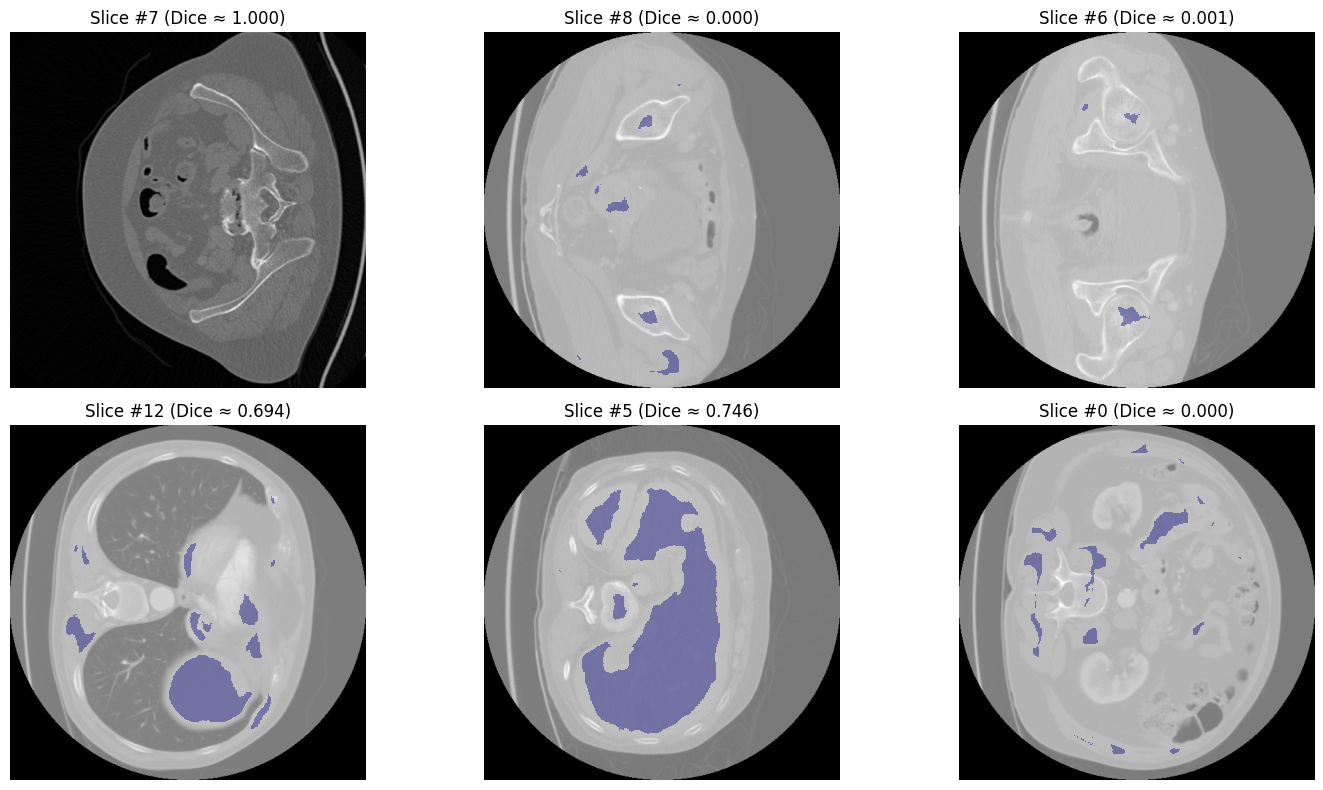

In [8]:
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras

# --- Reload trained model (if not already loaded) ---
model = keras.models.load_model(
    "best_unet_lits17_demo.keras",
    custom_objects={'bce_dice_loss': bce_dice_loss, 'dice_coef': dice_coef}
)
print("✅ Model reloaded successfully")

# --- Make sure folder exists ---
os.makedirs("outputs", exist_ok=True)

# --- Pick a few random samples from validation set ---
rng = np.random.default_rng(42)
sample_ids = rng.choice(len(X_val), size=min(6, len(X_val)), replace=False)

# --- Generate predictions ---
preds = model.predict(X_val[sample_ids])

# --- Display multiple overlays inline ---
plt.figure(figsize=(15, 8))
for i, idx in enumerate(sample_ids):
    pred_mask = (preds[i,:,:,0] > 0.5).astype(np.uint8)
    dice_val = dice_coef(Y_val[idx:idx+1], pred_mask[None,:,:,None]).numpy()

    plt.subplot(2, 3, i+1)
    plt.imshow(X_val[idx,:,:,0], cmap="gray")
    plt.imshow(np.ma.masked_where(pred_mask==0, pred_mask), alpha=0.4, cmap="jet")
    plt.title(f"Slice #{idx} (Dice ≈ {dice_val:.3f})")
    plt.axis("off")

    # optional: save individual overlay
    plt.imsave(f"outputs/prediction_overlay_{i+1}.png", 
               np.ma.masked_where(pred_mask==0, pred_mask), cmap="jet")

plt.tight_layout()
plt.savefig("outputs/prediction_grid.png", dpi=150, bbox_inches='tight')
plt.show()
